Importing Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# -----------------------
# STEP 1: Load all files
# -----------------------
df = pd.read_csv("dataset.csv")
desc = pd.read_csv("symptom_Description.csv")
prec = pd.read_csv("symptom_precaution.csv")

# ✅ Important fix: strip spaces from all column names
df.columns = df.columns.str.strip()
desc.columns = desc.columns.str.strip()
prec.columns = prec.columns.str.strip()

In [3]:

print(df.head())
print("\nColumns:", df.columns)



            Disease   Symptom_1              Symptom_2              Symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   
3  Fungal infection     itching              skin_rash    dischromic _patches   
4  Fungal infection     itching              skin_rash   nodal_skin_eruptions   

              Symptom_4 Symptom_5 Symptom_6 Symptom_7 Symptom_8 Symptom_9  \
0   dischromic _patches       NaN       NaN       NaN       NaN       NaN   
1                   NaN       NaN       NaN       NaN       NaN       NaN   
2                   NaN       NaN       NaN       NaN       NaN       NaN   
3                   NaN       NaN       NaN       NaN       NaN       NaN   
4                   NaN       NaN       NaN       NaN       NaN       NaN   

  Symptom_10 Symptom_11 Symptom_12 Symptom_13 Symp

In [4]:
# -----------------------
# STEP 2: Combine symptoms in one column
# -----------------------
symptom_cols = [c for c in df.columns if "Symptom" in c]
df["All_Symptoms"] = df[symptom_cols].astype(str).apply(
    lambda row: " ".join([s.replace(" ", "_") for s in row if s != "nan"]), axis=1
)

In [5]:
X = df["All_Symptoms"]
y = df["Disease"]

In [6]:
# -----------------------
# STEP 3: Train/Test Split + Train Model
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer=TfidfVectorizer()
X_train_tfidf= vectorizer.fit_transform(X_train)
X_test_tfidf= vectorizer.fit_transform(X_test)

# Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=500)

In [7]:
# -----------------------
# STEP 4: Check Accuracy
# -----------------------
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 1.0


In [8]:
# -----------------------
# STEP 5: Prediction Function
# -----------------------
def predict_disease(symptoms):
    input_text= " ".join([s.replace(" ","_") for s in symptoms])
    input_tfidf=vectorizer.transform([input_text])
    disease= model.predict(input_tfidf)[0]
    
    # get description
    description = desc[desc['Disease']==disease]["Description"].values
    description= description[0] if len(description)>0 else "No description available."
    
    #get precautions
    p=prec[prec["Disease"]==disease]
    precautions = p.iloc[0,1:].dropna().tolist() if not p.empty else ["No precaution listed"]

    return disease, description, precautions


In [9]:
print(desc.columns)
print(prec.columns)


Index(['Disease', 'Description'], dtype='object')
Index(['Disease', 'Precaution_1', 'Precaution_2', 'Precaution_3',
       'Precaution_4'],
      dtype='object')


In [10]:
print(desc.columns)


Index(['Disease', 'Description'], dtype='object')


In [11]:
# -----------------------
# Example Run
# -----------------------
if __name__ == "__main__":
    user_symptoms = ["itching", "skin rash", "nodal skin eruptions"]  # <- apne symptoms dalna
    disease, description, precautions = predict_disease(user_symptoms)

    print("\nPredicted Disease:", disease)
    print("Description:", description)
    print("Precautions:")
    
    for i, pr in enumerate(precautions, 1):
        print(f"{i}. {pr}")


Predicted Disease: Chronic cholestasis
Description: Chronic cholestatic diseases, whether occurring in infancy, childhood or adulthood, are characterized by defective bile acid transport from the liver to the intestine, which is caused by primary damage to the biliary epithelium in most cases
Precautions:
1. cold baths
2. anti itch medicine
3. consult doctor
4. eat healthy


X-ray chest model


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -----------------------
# STEP 1: Transformations
# -----------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalization
])

# -----------------------
# STEP 2: Load Dataset
# -----------------------
train_data = datasets.ImageFolder("chest_xray/train", transform=transform)
test_data = datasets.ImageFolder("chest_xray/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# -----------------------
# STEP 3: Model - Pretrained ResNet18
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze layers

# Replace last layer for binary classification (Normal vs Pneumonia)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# -----------------------
# STEP 4: Loss and Optimizer
# -----------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# -----------------------
# STEP 5: Training Loop
# -----------------------
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# -----------------------
# STEP 6: Evaluation
# -----------------------
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")




c:\Users\shriv\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shriv\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 0.3221
Epoch 2/5, Loss: 0.1693
Epoch 3/5, Loss: 0.1492
Epoch 4/5, Loss: 0.1474
Epoch 5/5, Loss: 0.1355
Test Accuracy: 84.29%


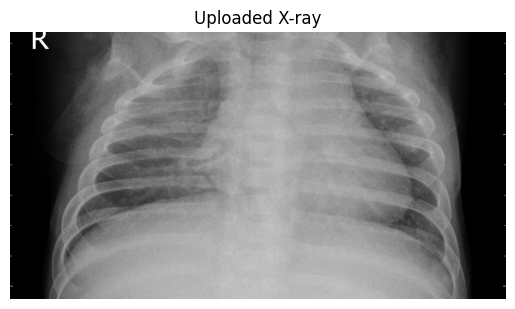

Prediction for 'C:\Users\shriv\Desktop\AI Personal Health Assistant\chest_xray\test\PNEUMONIA\person33_virus_72.jpeg': PNEUMONIA
PNEUMONIA


In [ ]:
# -----------------------------
# Prediction
# -----------------------------

from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# -----------------------------
# Transform (same as training)
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# -----------------------------
# Prediction Function
# -----------------------------
def predict_xray(model, image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB")

    # Display image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded X-ray")
    plt.show()

    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
    classes = ["NORMAL", "PNEUMONIA"]
    return classes[predicted.item()]

# -----------------------------
# Test a single image
# -----------------------------
test_image_path = input("Enter path to test image: ")  #image path
result = predict_xray(model, test_image_path)
print(f"Prediction for '{test_image_path}': {result}")
print(result)


SKIN CANCER

In [22]:
# -----------------------------
# 3️⃣ SKIN CANCER → HAM10000
# -----------------------------
# Transform for ResNet

from torch.utils.data import Dataset, DataLoader
skin_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

# Custom Dataset
class HAMDataset(Dataset):
    def __init__(self, csv_file, img_dirs, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dirs = img_dirs
        self.transform = transform
        self.classes = sorted(self.data['dx'].unique())
        self.class_to_idx = {cls_name:i for i,cls_name in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image_id'] + ".jpg"
        image = None
        # Loop through folders to find image
        for folder in self.img_dirs:
            img_path = f"{folder}/{img_name}"
            try:
                image = Image.open(img_path).convert("RGB")
                break
            except FileNotFoundError:
                continue
        if image is None:
            raise FileNotFoundError(f"{img_name} not found in any folder.")
        
        label_name = self.data.iloc[idx]['dx']
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)
        return image, label

# Paths
csv_file = "skin_cancer/HAM10000_metadata.csv"
img_dirs = ["skin_cancer/HAM10000_images_part_1", "skin_cancer/HAM10000_images_part_2"]

# Dataset & DataLoader
train_skin = HAMDataset(csv_file, img_dirs, transform=skin_transform)
train_loader_skin = DataLoader(train_skin, batch_size=32, shuffle=True)

# Model
skin_model = models.resnet18(pretrained=True)
for param in skin_model.parameters():
    param.requires_grad = False
skin_model.fc = nn.Linear(skin_model.fc.in_features, len(train_skin.classes))
skin_model = skin_model.to(device)

# Loss & Optimizer
criterion_skin = nn.CrossEntropyLoss()
optimizer_skin = optim.Adam(skin_model.fc.parameters(), lr=0.001)

# Quick training (demo 1 epoch)
skin_model.train()
for images, labels in train_loader_skin:
    images, labels = images.to(device), labels.to(device)
    optimizer_skin.zero_grad()
    outputs = skin_model(images)
    loss = criterion_skin(outputs, labels)
    loss.backward()
    optimizer_skin.step()
print("Skin Cancer model trained!")



c:\Users\shriv\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shriv\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Skin Cancer model trained!


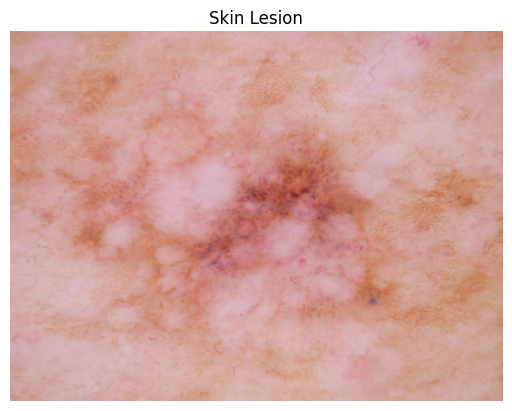


Skin Cancer Prediction for 'C:\Users\shriv\Desktop\AI Personal Health Assistant\skin_cancer\HAM10000_images_part_2\ISIC_0029353.jpg': Benign keratosis-like lesions
Benign keratosis-like lesions


In [23]:
# -----------------------------
# Prediction Function
# -----------------------------
def predict_skin(model, image_path):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    plt.imshow(img)
    plt.axis('off')
    plt.title("Skin Lesion")
    plt.show()
    
    img_tensor = skin_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs,1)
    return train_skin.classes[predicted.item()]

# -----------------------------
# SKIN CANCER PREDICTION
# -----------------------------
# Test image path
test_skin_image =input("Enter path to test image: ") 
# Prediction
skin_result = predict_skin(skin_model, test_skin_image)
print(f"\nSkin Cancer Prediction for '{test_skin_image}': {skin_result}")
print(skin_result)


In [24]:
# -----------------------
# Save Model
# -----------------------

# 1️.Chest X-ray Pneumonia model
torch.save(model.state_dict(), "pneumonia_model.pth")
print("Chest X-ray model saved successfully!")

# 2️.Skin Cancer HAM10000 model
torch.save(skin_model.state_dict(), "skin_cancer_model.pth")
print("Skin Cancer model saved successfully!")

# 3️.Symptoms → Disease data
df.to_csv("dataset.csv", index=False)
desc.to_csv("symptom_Description.csv", index=False)
prec.to_csv("symptom_precaution.csv", index=False)
print("Symptom dataset saved successfully!")


Chest X-ray model saved successfully!
Skin Cancer model saved successfully!
Symptom dataset saved successfully!
